# Convert MATLAB File Into PNG File

## Import

In [1]:
import os
import cv2
from scipy import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import tensorflow as tf

# MATLAB files

### Будем использовать файлы сегментации изображений с открытым исходным кодом и соответствующие им оригинальные изображения.

https://github.com/bearpaw/clothing-co-parsing


In [2]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

zsh:cd:1: no such file or directory: ../lib
Cloning into 'clothing-co-parsing'...
remote: Enumerating objects: 4234, done.
remote: Total 4234 (delta 0), reused 0 (delta 0), pack-reused 4234
Receiving objects: 100% (4234/4234), 124.59 MiB | 2.88 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.
Updating files: 100% (4202/4202), done.


# Read Images, Segmentations and Labels

### 1. Read Images

In [2]:
number_of_images = []
for root, dirs, files in os.walk("lib/clothing-co-parsing/photos", topdown=False):
    number_of_images.append((len(files)))

In [5]:
images = []

for i in range(1, number_of_images[0]):
    url = 'lib/clothing-co-parsing/photos/%04d.jpg'%(i)
    img = cv2.imread(url, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.convert_to_tensor(img)
    img = tf.image.resize_with_crop_or_pad(img,825,550)
    images.append(img)

In [6]:
images[0].shape

TensorShape([825, 550, 3])

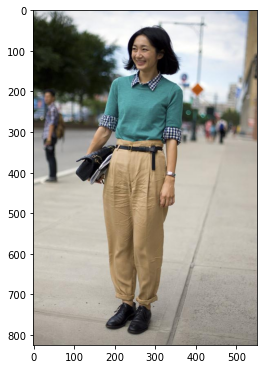

In [7]:
plt.figure(figsize=(4,7))
plt.imshow(images[57])
plt.show()

### 2. Segmentations

In [8]:
pixel_level_of_images = []
for root, dirs, files in os.walk('lib/clothing-co-parsing/annotations/pixel-level'):
    pixel_level_of_images.append(len(files))

In [9]:
segmentations = []

for i in range(1,pixel_level_of_images[0]):
    url = 'lib/clothing-co-parsing/annotations/pixel-level/%04d.mat'%(i)
    # Чтение файлов .mat
    file = io.loadmat(url)
    mask = tf.convert_to_tensor(file['groundtruth'])
    # resize ожидает 3D-изображения, но мы получили 2D-изображение в оттенках серого
    mask = tf.expand_dims(mask,-1)
    mask = tf.image.resize_with_crop_or_pad(mask,825,550)
    segmentations.append(mask)

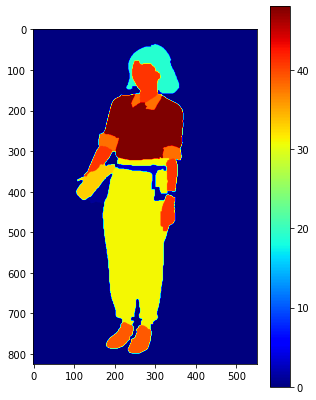

In [10]:
plt.figure(figsize=(5,7))
plt.imshow(segmentations[57], cmap='jet')
plt.colorbar()
plt.show()

In [11]:
list_unique_segmentations = np.unique(segmentations)

### 3. Read Labels

In [12]:
label_url = 'lib/clothing-co-parsing/label_list'
label_file = io.loadmat(label_url)['label_list']

In [13]:
labels = list(map(lambda x: x[0], label_file[0]))
labels

['null',
 'accessories',
 'bag',
 'belt',
 'blazer',
 'blouse',
 'bodysuit',
 'boots',
 'bra',
 'bracelet',
 'cape',
 'cardigan',
 'clogs',
 'coat',
 'dress',
 'earrings',
 'flats',
 'glasses',
 'gloves',
 'hair',
 'hat',
 'heels',
 'hoodie',
 'intimate',
 'jacket',
 'jeans',
 'jumper',
 'leggings',
 'loafers',
 'necklace',
 'panties',
 'pants',
 'pumps',
 'purse',
 'ring',
 'romper',
 'sandals',
 'scarf',
 'shirt',
 'shoes',
 'shorts',
 'skin',
 'skirt',
 'sneakers',
 'socks',
 'stockings',
 'suit',
 'sunglasses',
 'sweater',
 'sweatshirt',
 'swimwear',
 't-shirt',
 'tie',
 'tights',
 'top',
 'vest',
 'wallet',
 'watch',
 'wedges']

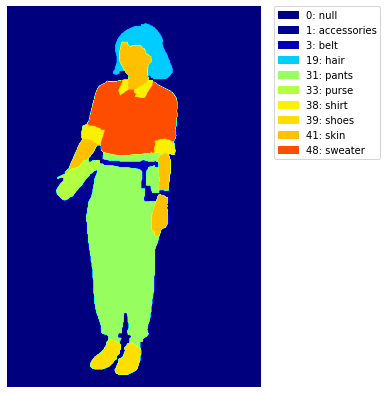

In [14]:
plt.figure(figsize=(7,7))
annotations = np.unique(segmentations[57])
# read the names
names = [labels[a] for a in annotations]
norm = mpl.colors.Normalize(vmin=list_unique_segmentations.min(), vmax=list_unique_segmentations.max())

plt.imshow(segmentations[57], cmap='jet', norm=norm)
plt.axis('off')

PATCHES = [mpl.patches.Patch(color=mpl.cm.jet(norm(a)), label=f'{a}: {names[i]}') for i,a in enumerate(annotations)]
plt.legend(handles=PATCHES, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Display Images, Segmentations and Labels

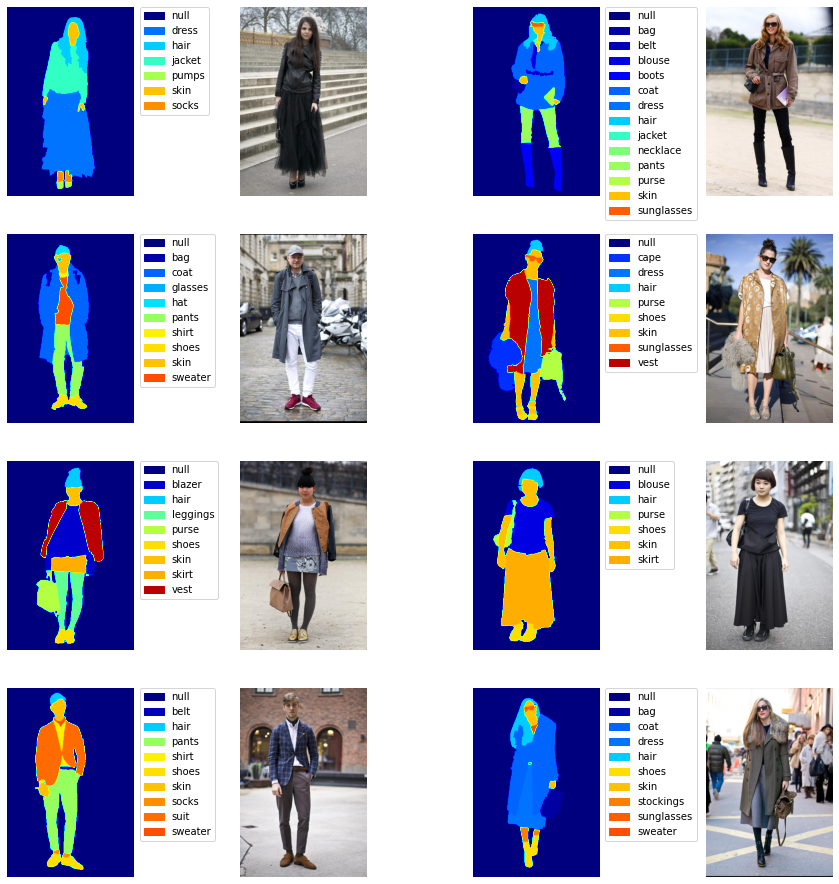

In [16]:
plt.figure(figsize=(16,16))
for i in range(1,9):
    plt.subplot(4,4,2*i-1)
    annotations = np.unique(segmentations[i])
    names = [labels[a] for a in annotations]
    plt.imshow(segmentations[i], cmap='jet', norm=norm)
    plt.axis('off')
    PATCHES = [mpl.patches.Patch(color=mpl.cm.jet(norm(a)), label=names[i]) for i,a in enumerate(annotations)]
    plt.legend(handles=PATCHES, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.subplot(4,4,2*i)
    plt.imshow(images[i])
    plt.axis('off')
    
plt.show()

# Convert Images and Segmentations into PNG File

Изображения PNG - это несжатые форматы, следовательно, без потерь. Получение перехода без потерь имеет решающее значение, поскольку маски сегментации состоят из целых чисел, которые относятся к классам объектов. В более ранних версиях этого ноутбука преобразование производилось в форматы JPEG. Хотя JPEG дает сжатые и компактные выходные данные, классы сегментации скомпрометированы. Например, преобразование создает новые классы в масках, хотя в исходных масках таких классов нет. Из-за таких переходов с потерями сегменты обучения могут стать сложными и вводить в заблуждение. Следовательно, последние версии этого ноутбука предпочитают преобразование в форматы PNG.

### 1. Convert Images

In [18]:
for i in tqdm(range(len(images))):
    img = images[i]
    # encode into PNG
    img = tf.io.encode_png(img)
    # create a path
    path = os.path.join('IMAGES','img_%04d.png'%(i+1))
    file_name = tf.constant(path)
    # write the PNG file
    tf.io.write_file(file_name, img)

100%|██████████| 2097/2097 [04:38<00:00,  7.53it/s]


### Check for proper encoding

In [54]:
# a list to store image paths
PNG_IMAGES = []
for root, dirs, files in os.walk('./IMAGES'):
    for file in files:
        if 'img_' in file:
            # get image paths
            path = os.path.join(root, file)
            PNG_IMAGES.append(path)

In [55]:
PNG_IMAGES.sort()

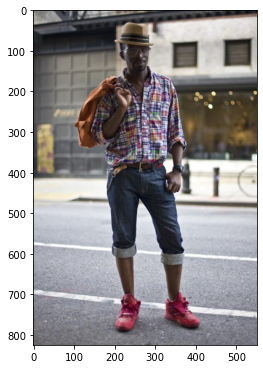

In [59]:
im = tf.io.read_file(PNG_IMAGES[47])
dec = tf.io.decode_png(im, channels=3, dtype=tf.dtypes.uint8)

plt.figure(figsize=(4,7))
plt.imshow(dec)
plt.show()

### 2. Convert Segmentations

In [21]:
# encode masks into PNG files
for i in tqdm(range(len(segmentations))):
              
    seg = tf.io.encode_png(segmentations[i])

    path = os.path.join('MASKS','seg_%04d.png'%(i+1))
    file_name = tf.constant(path)
    # write the PNG file
    tf.io.write_file(file_name, seg)

100%|██████████| 1003/1003 [00:06<00:00, 150.37it/s]


In [22]:
PNG_MASKS = []

for root, dirs, files in os.walk('./MASKS'):
    for file in files:
        if 'seg_' in file:
            path = os.path.join(root, file)
            PNG_MASKS.append(path)

In [60]:
PNG_MASKS.sort()

### Check for proper encoding

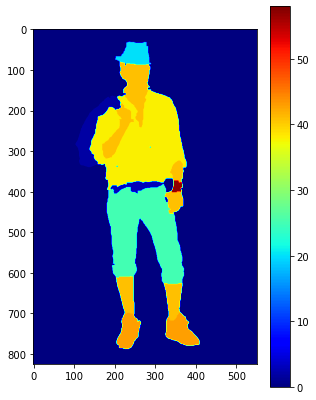

In [61]:
im = tf.io.read_file(PNG_MASKS[47])
dec = tf.io.decode_png(im, channels=0, dtype = tf.dtypes.uint8)

plt.figure(figsize=(5,7))
plt.imshow(dec, cmap='jet', norm=norm)
plt.colorbar()
plt.show()

# Write Files to Output

### Архивируем изображения и сегменты (пригодится для загрузки!)

In [185]:
!zip -r -q png_images.zip IMAGES/
!zip -r -q png_masks.zip MASKS/

### Запишем имена меток классов в файл CSV.

In [186]:
labels = np.array(labels)
labels = pd.Series(labels, name='label_list')
labels.to_csv('labels.csv')